#IMPORTING THE REQUIRED LIBRARIES


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern, DotProduct, ConstantKernel as C

# IMPORTING THE DATA FILE

In [24]:
!mkdir data/
!wget https://github.com/Anand2723/DATA-FILE/raw/main/Data%20Sheet%20for%20Gas%20Holdup.xlsx

mkdir: cannot create directory ‘data/’: File exists
--2024-04-25 11:07:09--  https://github.com/Anand2723/DATA-FILE/raw/main/Data%20Sheet%20for%20Gas%20Holdup.xlsx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Anand2723/DATA-FILE/main/Data%20Sheet%20for%20Gas%20Holdup.xlsx [following]
--2024-04-25 11:07:09--  https://raw.githubusercontent.com/Anand2723/DATA-FILE/main/Data%20Sheet%20for%20Gas%20Holdup.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 434653 (424K) [application/octet-stream]
Saving to: ‘Data Sheet for Gas Holdup.xlsx.2’

Data Sheet for Gas  100%[===================>] 424.47K 

In [25]:
# Read Excel file into DataFrame
df = pd.read_excel('Data Sheet for Gas Holdup.xlsx')
print(df.head())

               Authors  Gas holdup  Column diameter(m)  Liquid height (m)  \
0  Braulick et al 1965    0.029356                 0.1                0.4   
1  Braulick et al 1965    0.041423                 0.1                0.4   
2  Braulick et al 1965    0.060100                 0.1                0.4   
3  Braulick et al 1965    0.079486                 0.1                0.4   
4  Braulick et al 1965    0.094500                 0.1                0.4   

   Sparger hole diameter (m)  Sparger Encode       %FA  \
0                    0.00367               4  0.538756   
1                    0.00367               4  0.538756   
2                    0.00367               4  0.538756   
3                    0.00367               4  0.538756   
4                    0.00367               4  0.538756   

   Density of Gas (kg/m3)  Viscosity of Gas (Pa.s)  \
0                    1.18                 0.000018   
1                    1.18                 0.000018   
2                    1.18 

In [26]:
print(df.shape)
print(df.columns)
print(df.index)

(4042, 22)
Index(['Authors', 'Gas holdup', 'Column diameter(m)', 'Liquid height (m)',
       'Sparger hole diameter (m)', 'Sparger Encode', '%FA',
       'Density of Gas (kg/m3)', 'Viscosity of Gas (Pa.s)',
       'Molecular Weight of gas (kg/kmol)', 'Density of Liquid (kg/m3)',
       'Viscosity of Liquid (Pa.s)', 'Surface Tension of Liquid (N/m)',
       'i+ (k.ion/m3)', 'Temperature (K)', 'Pressure (kPa)',
       'Superficial gas velocity (m/s)', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')
RangeIndex(start=0, stop=4042, step=1)


#DATA PREPROCESSING

 ## DATA CLEANING
 Making a seperate database for the Sparger Encoding.


In [27]:
Sparger_Encoding = df.iloc[:, -2:].dropna()
Sparger_Encoding.columns = ['Code', 'Sparger Type']
print(Sparger_Encoding.shape)
print(Sparger_Encoding.head())

(13, 2)
  Code       Sparger Type
2    1  Nozzle plate (TP)
3    2     Single Nozzle 
4    3   Perforated Plate
5    4              Cross
6    5    Six Arm Sparger


Dropping the redundant columns.

In [28]:
df = df.drop(columns = ['Authors', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'])
df.head()

,Gas holdup,Column diameter(m),Liquid height (m),Sparger hole diameter (m),Sparger Encode,%FA,Density of Gas (kg/m3),Viscosity of Gas (Pa.s),Molecular Weight of gas (kg/kmol),Density of Liquid (kg/m3),Viscosity of Liquid (Pa.s),Surface Tension of Liquid (N/m),i+ (k.ion/m3),Temperature (K),Pressure (kPa),Superficial gas velocity (m/s)
0,0.029356,0.1,0.4,0.00367,4,0.538756,1.18,0.000018,28.84,1010.0,0.0011,0.073,1.5,298.0,100.0,0.017209
1,0.041423,0.1,0.4,0.00367,4,0.538756,1.18,0.000018,28.84,1010.0,0.0011,0.073,1.5,298.0,100.0,0.026053
2,0.060100,0.1,0.4,0.00367,4,0.538756,1.18,0.000018,28.84,1010.0,0.0011,0.073,1.5,298.0,100.0,0.034700
3,0.079486,0.1,0.4,0.00367,4,0.538756,1.18,0.000018,28.84,1010.0,0.0011,0.073,1.5,298.0,100.0,0.042296
4,0.094500,0.1,0.4,0.00367,4,0.538756,1.18,0.000018,28.84,1010.0,0.0011,0.073,1.5,298.0,100.0,0.051100


##Exploratory Data Analysis (EDA)

Finding the basic data characteristics like Shape, Columns list and Index list.

In [29]:
print(df.shape)
print(df.columns)
print(df.index)

(4042, 16)
Index(['Gas holdup', 'Column diameter(m)', 'Liquid height (m)',
       'Sparger hole diameter (m)', 'Sparger Encode', '%FA',
       'Density of Gas (kg/m3)', 'Viscosity of Gas (Pa.s)',
       'Molecular Weight of gas (kg/kmol)', 'Density of Liquid (kg/m3)',
       'Viscosity of Liquid (Pa.s)', 'Surface Tension of Liquid (N/m)',
       'i+ (k.ion/m3)', 'Temperature (K)', 'Pressure (kPa)',
       'Superficial gas velocity (m/s)'],
      dtype='object')
RangeIndex(start=0, stop=4042, step=1)


Describing the overall data like the mean , number of cells, and the percentile ranges.

In [30]:
df.describe()

,Gas holdup,Column diameter(m),Liquid height (m),Sparger hole diameter (m),Sparger Encode,%FA,Density of Gas (kg/m3),Viscosity of Gas (Pa.s),Molecular Weight of gas (kg/kmol),Density of Liquid (kg/m3),Viscosity of Liquid (Pa.s),Surface Tension of Liquid (N/m),i+ (k.ion/m3),Temperature (K),Pressure (kPa),Superficial gas velocity (m/s)
count,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000,4.042000e+03,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000,4042.000000
mean,0.183150,0.285216,1.424668,0.007043,3.622464,0.974343,2.319405,1.821745e-05,28.655366,991.189912,0.003511,0.065849,0.107800,298.054453,200.232188,0.100881
std,0.104527,0.160698,1.007980,0.013789,1.738673,2.168846,5.905465,7.451508e-07,2.694709,85.582128,0.024519,0.015093,0.821268,7.660137,509.101265,0.086087
min,0.000401,0.090000,0.204073,0.000300,1.000000,0.010000,0.082900,9.200000e-06,2.000000,684.000000,0.000295,0.018700,0.000000,285.500000,100.000000,0.000338
25%,0.103717,0.150000,0.680430,0.001000,3.000000,0.184900,1.180000,1.810000e-05,28.840000,998.000000,0.000891,0.070920,0.000000,298.000000,100.000000,0.034000
50%,0.174561,0.300000,1.280000,0.002000,3.000000,0.420000,1.184000,1.810000e-05,28.840000,1000.000000,0.001000,0.072000,0.000000,298.000000,100.000000,0.073990
75%,0.249926,0.385000,1.969813,0.006000,3.000000,0.538756,1.185000,1.836000e-05,28.840000,1000.000000,0.001000,0.072000,0.000000,298.000000,101.300000,0.150215
max,0.665280,1.000000,7.230000,0.087000,13.000000,18.100000,76.830000,2.400000e-05,44.000000,1462.000000,0.500000,0.091900,15.900000,448.000000,6600.000000,0.600900


Checking if any null values are present in the dataset.

In [31]:
df.isna().sum()

Gas holdup                           0
Column diameter(m)                   0
Liquid height (m)                    0
Sparger hole diameter (m)            0
Sparger Encode                       0
%FA                                  0
Density of Gas (kg/m3)               0
Viscosity of Gas (Pa.s)              0
Molecular Weight of gas (kg/kmol)    0
Density of Liquid (kg/m3)            0
Viscosity of Liquid (Pa.s)           0
Surface Tension of Liquid (N/m)      0
i+ (k.ion/m3)                        0
Temperature (K)                      0
Pressure (kPa)                       0
Superficial gas velocity (m/s)       0
dtype: int64

Plotting the scatter plots of Gas Holdup v/s all input features.

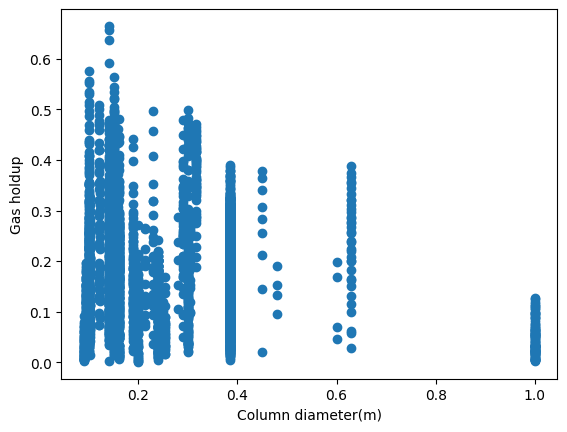

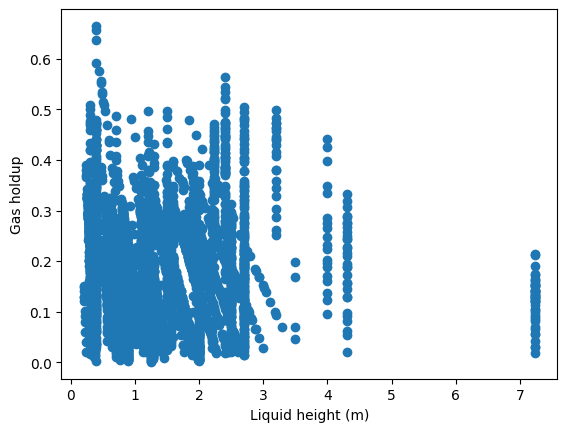

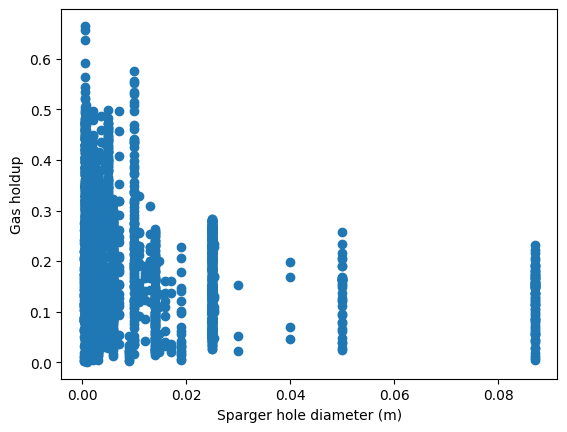

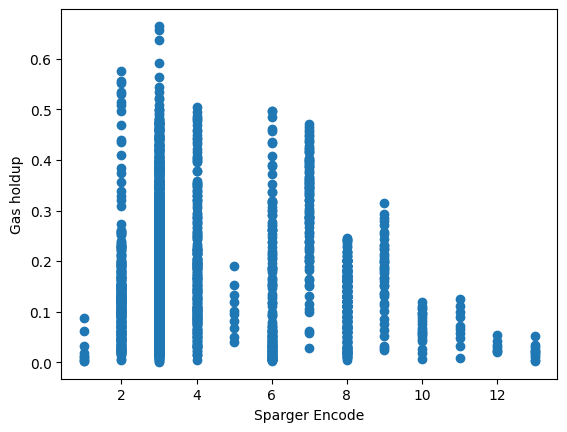

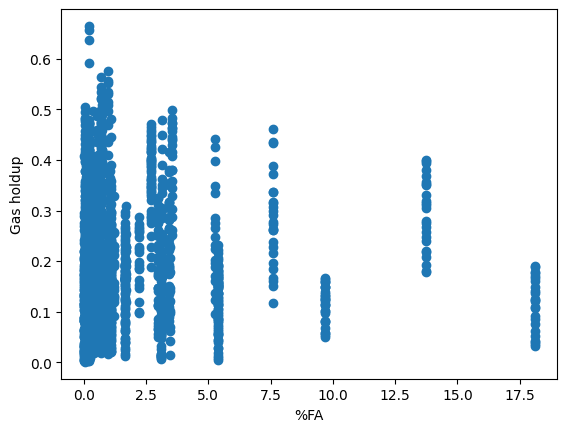

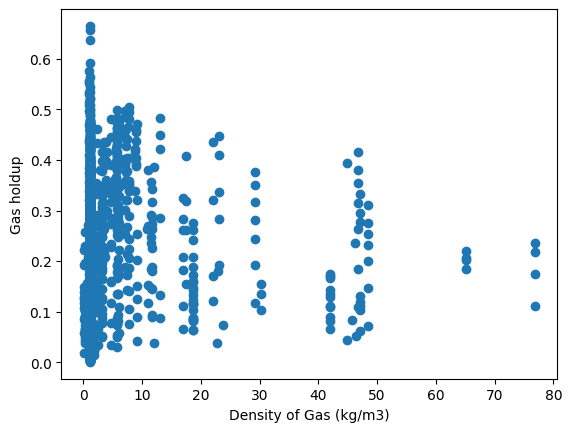

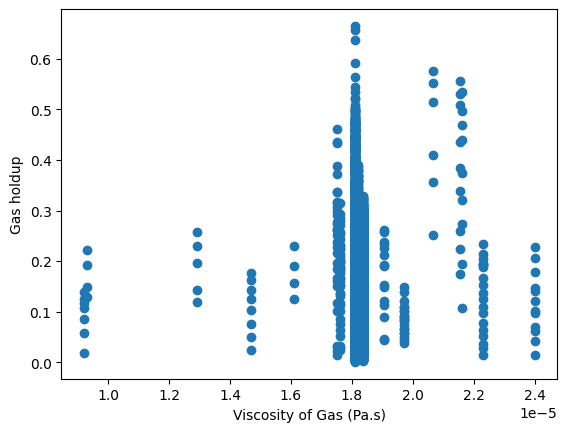

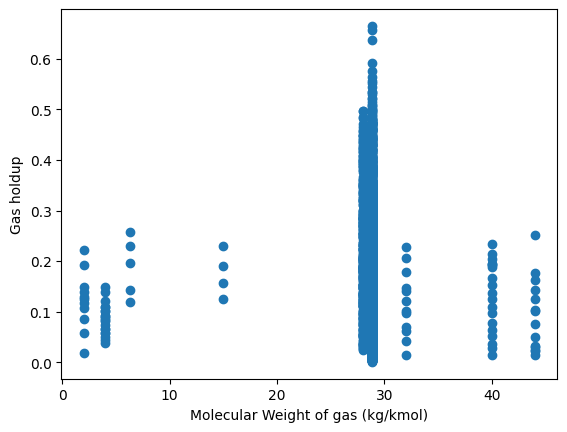

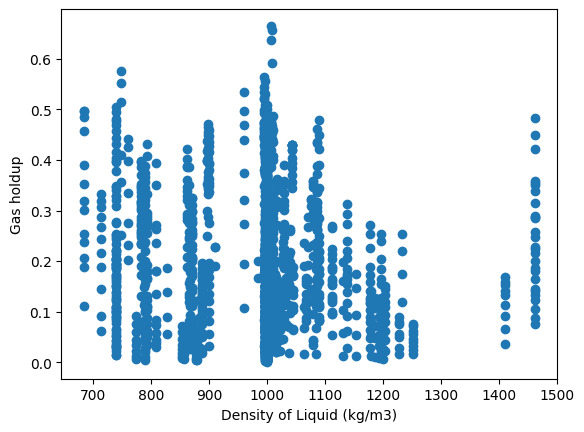

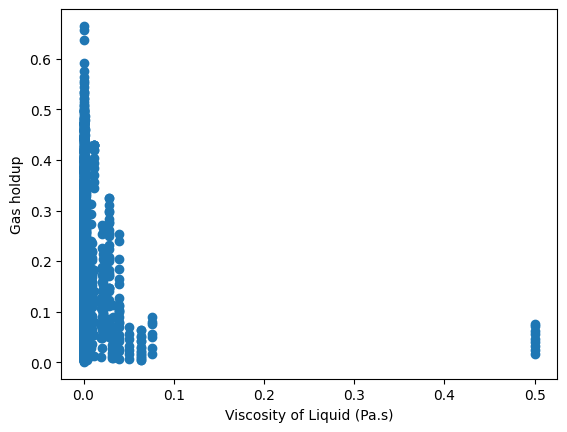

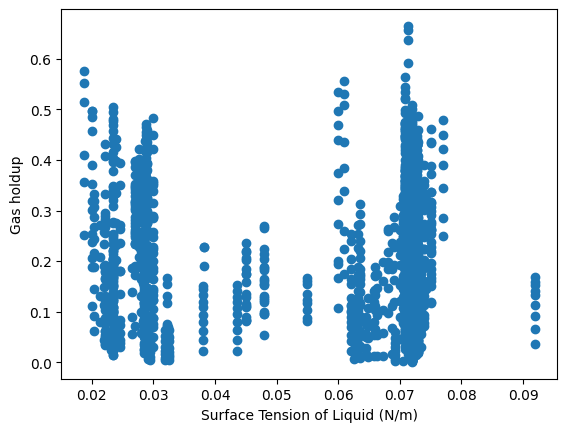

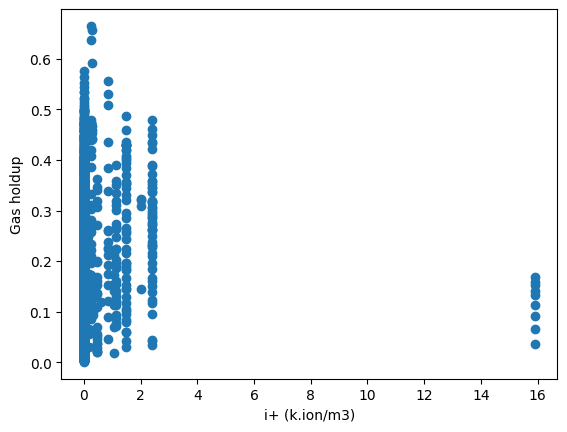

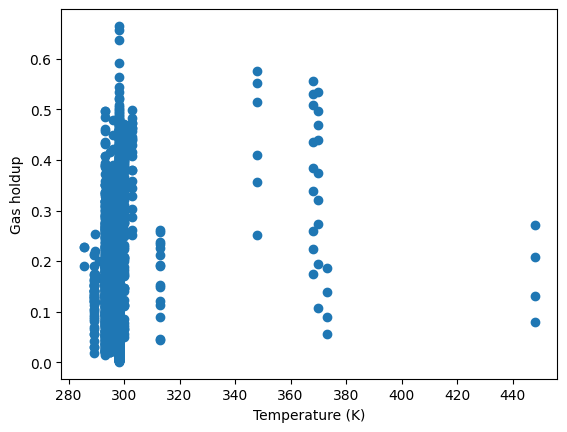

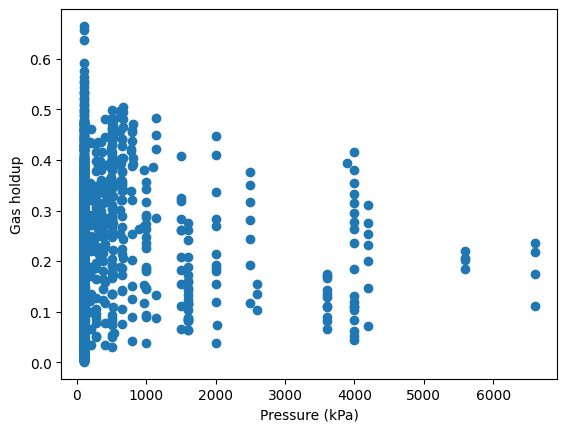

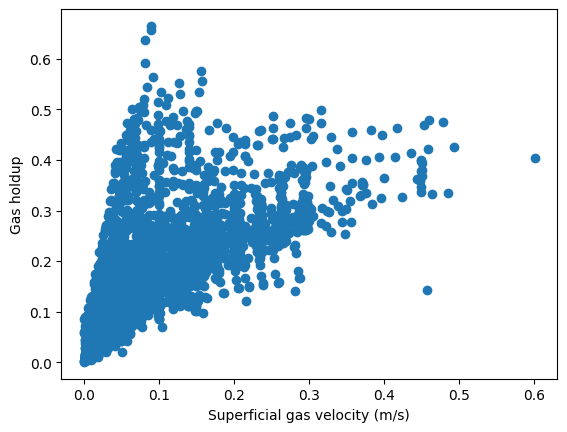

In [32]:
gas_holdup = df['Gas holdup']

for column in df.columns:
    if column != 'Gas holdup':
        plt.scatter(df[column], gas_holdup)
        plt.xlabel(column)
        plt.ylabel('Gas holdup')
        plt.show()

Plotting the correlation matrix heatmap for the dataset.

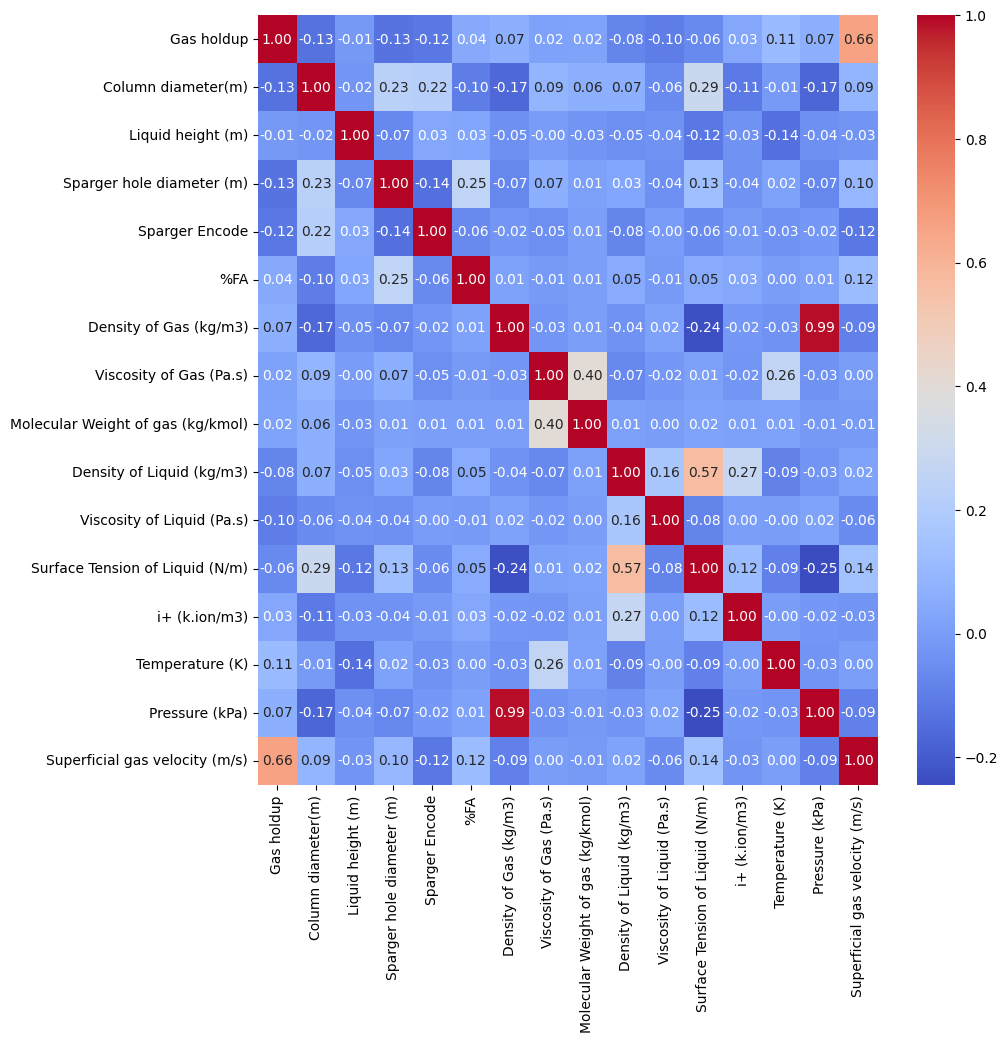

In [33]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")
plt.show()

Plotting the boxplots of all the labels.




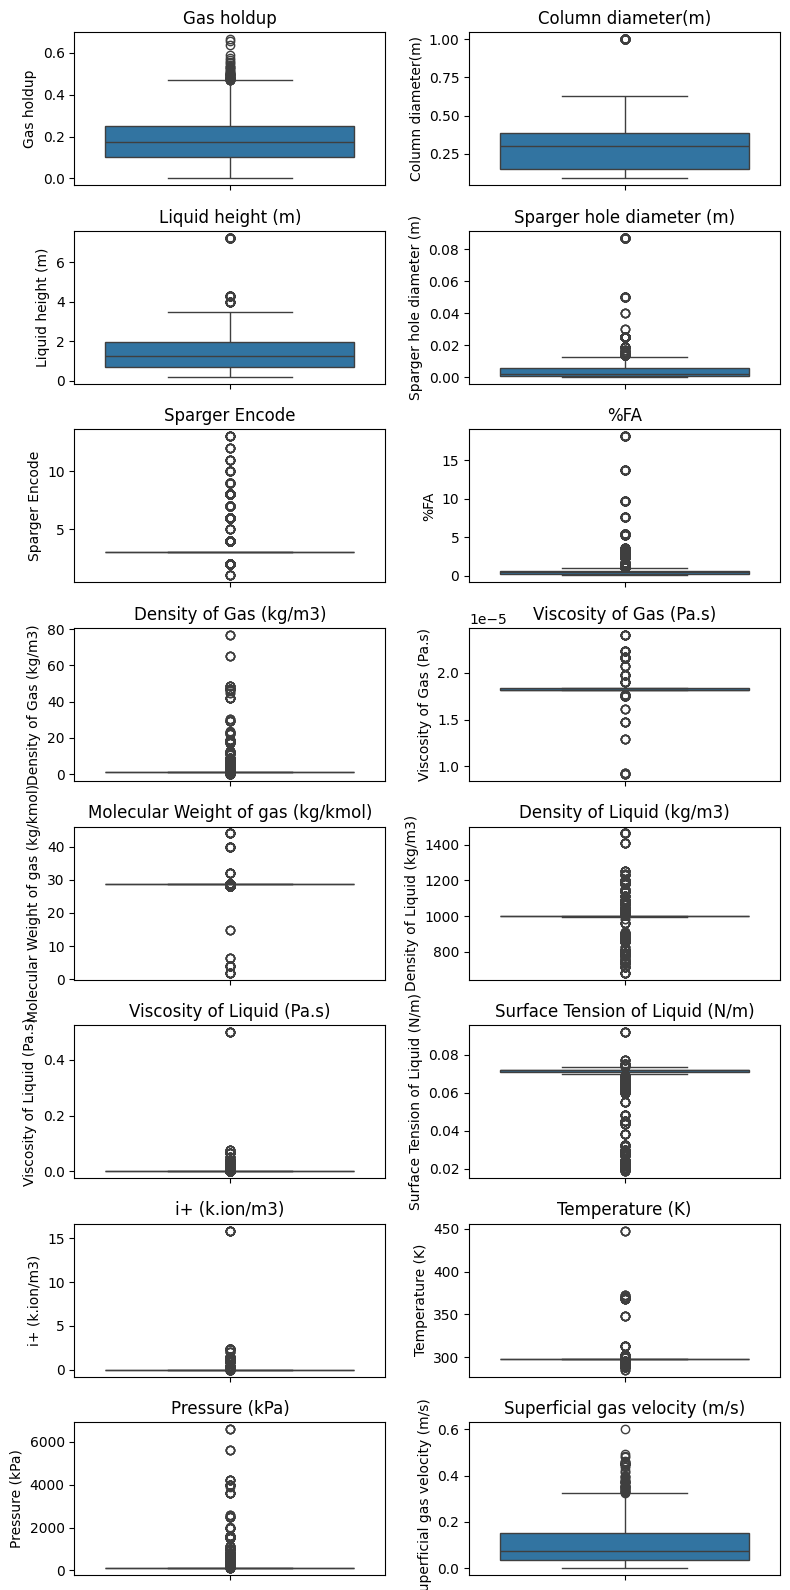

In [34]:
columns = df.columns
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 16))
axes = axes.ravel()
for i, col in enumerate(columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

##Outlier Analysis and Removal

Plotting the boxplot for the target variable - Gas Holdup.

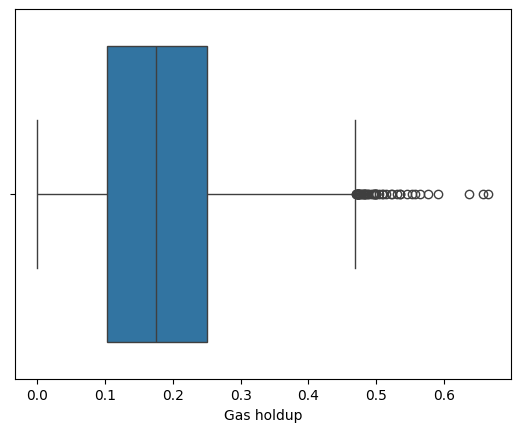

In [35]:
sns.boxplot(x = df["Gas holdup"])
plt.show()

Finding the number of outliers using Z-Score method.


In [36]:
z_scores = stats.zscore(df['Gas holdup'])
outliers = df['Gas holdup'][abs(z_scores) > 3]
num_outliers = len(outliers)
print(f"Number of outliers using z-score method: {num_outliers}")

Number of outliers using z-score method: 23


Finding the number of outlier using the IQR method.

In [37]:
Q1 = df['Gas holdup'].quantile(0.25)
Q3 = df['Gas holdup'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[((df['Gas holdup'] < lower_bound) | (df['Gas holdup'] > upper_bound))]
print('Number of outliers using IQR:', len(outliers))

Number of outliers using IQR: 49


Checking if the target variable has a gaussian/normal distribution.

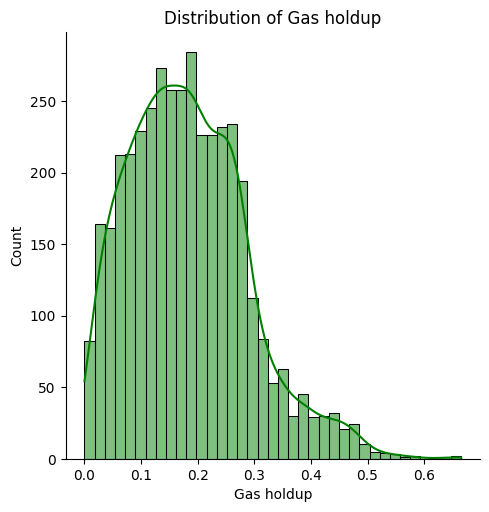

Shapiro-Wilk test results: statistic = 0.9686, p-value = 0.0000
The data is not normally distributed.


In [38]:
sns.displot(df['Gas holdup'], kde=True, color='green')
plt.title('Distribution of Gas holdup')
plt.show()

# Perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(df['Gas holdup'])
print('Shapiro-Wilk test results: statistic = %.4f, p-value = %.4f' % (stat, p))

# If p-value is less than 0.05, reject the null hypothesis that the data is normally distributed
if p < 0.05:
    print('The data is not normally distributed.')
else:
    print('The data is normally distributed.')

Removing the outliers using the IQR method as the target variable is not normally distributed.

In [39]:
df = df[~((df['Gas holdup'] < lower_bound) | (df['Gas holdup'] > upper_bound))]
print("Shape after removing the outliers:", df.shape)

Shape after removing the outliers: (3993, 16)


##Data Scaling

Using the normalization method of data scaling as the target variable is not normally distributed.

In [40]:
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm.columns = df.columns
df_norm = df_norm.drop(columns = ['Sparger Encode'])
df_norm = pd.concat([df_norm, df['Sparger Encode']], axis=1)
df_norm.head()

,Gas holdup,Column diameter(m),Liquid height (m),Sparger hole diameter (m),%FA,Density of Gas (kg/m3),Viscosity of Gas (Pa.s),Molecular Weight of gas (kg/kmol),Density of Liquid (kg/m3),Viscosity of Liquid (Pa.s),Surface Tension of Liquid (N/m),i+ (k.ion/m3),Temperature (K),Pressure (kPa),Superficial gas velocity (m/s),Sparger Encode
0,0.061784,0.010989,0.027886,0.03887,0.029229,0.014295,0.601351,0.639048,0.419023,0.001612,0.741803,0.09434,0.076923,0.0,0.028092,4
1,0.087532,0.010989,0.027886,0.03887,0.029229,0.014295,0.601351,0.639048,0.419023,0.001612,0.741803,0.09434,0.076923,0.0,0.042819,4
2,0.127385,0.010989,0.027886,0.03887,0.029229,0.014295,0.601351,0.639048,0.419023,0.001612,0.741803,0.09434,0.076923,0.0,0.057216,4
3,0.168751,0.010989,0.027886,0.03887,0.029229,0.014295,0.601351,0.639048,0.419023,0.001612,0.741803,0.09434,0.076923,0.0,0.069864,4
4,0.200788,0.010989,0.027886,0.03887,0.029229,0.014295,0.601351,0.639048,0.419023,0.001612,0.741803,0.09434,0.076923,0.0,0.084524,4


In [41]:
df_norm.describe()

,Gas holdup,Column diameter(m),Liquid height (m),Sparger hole diameter (m),%FA,Density of Gas (kg/m3),Viscosity of Gas (Pa.s),Molecular Weight of gas (kg/kmol),Density of Liquid (kg/m3),Viscosity of Liquid (Pa.s),Surface Tension of Liquid (N/m),i+ (k.ion/m3),Temperature (K),Pressure (kPa),Superficial gas velocity (m/s),Sparger Encode
count,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000,3993.000000
mean,0.381396,0.216262,0.173662,0.078364,0.053348,0.029055,0.608960,0.634622,0.395473,0.006502,0.645360,0.006726,0.076478,0.015327,0.166444,3.627348
std,0.210227,0.176823,0.143362,0.159855,0.120480,0.077299,0.049803,0.064548,0.108869,0.049364,0.204718,0.051877,0.044030,0.078680,0.142616,1.744839
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.218679,0.065934,0.068518,0.008074,0.009076,0.014295,0.601351,0.639048,0.403599,0.001194,0.713388,0.000000,0.076923,0.000000,0.054728,3.000000
50%,0.367436,0.230769,0.153137,0.019608,0.022664,0.014347,0.601351,0.639048,0.406170,0.001412,0.728142,0.000000,0.076923,0.000000,0.121162,3.000000
75%,0.528108,0.324176,0.250186,0.065744,0.027674,0.014360,0.618919,0.639048,0.406170,0.001412,0.728142,0.000000,0.076923,0.000200,0.249520,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


##Seperating the target variable from the main dataset.

In [42]:
y = df_norm['Gas holdup']
X = df_norm.drop(columns = ['Gas holdup'])

##Feature Engineering

Performing feature engineering using Principal Component Analysis.

In [43]:
pca = PCA()
pca.fit(X)

PCA()

Plotting the Cumulative Explained Variance plot. The explained variance ratio tells you the proportion of variance in the original data that is captured by each principal component.

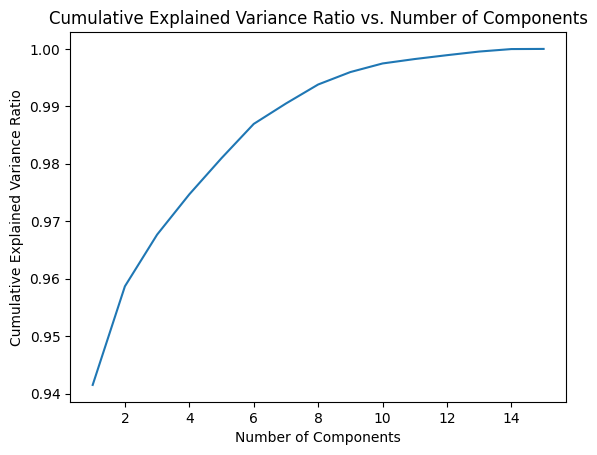

In [44]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

Finding the optimum number of features to be used for model development.

In [45]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Number of components for 95% variance: {n_components}')

Number of components for 95% variance: 2


Applying PCA to the dataset.

In [46]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

Plotting the scree plot.

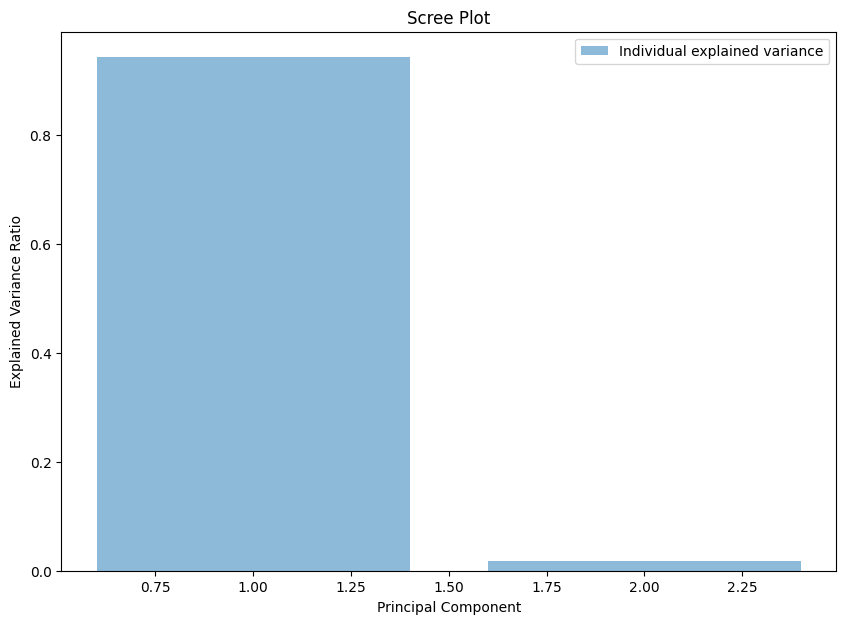

In [47]:
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.show()

Converting the numpy array to pandas dataframe for further use.

In [48]:
X_pca = pd.DataFrame(X_pca)
X_pca.columns = [f'PC{i+1}' for i in range(n_components)]
X_pca.head()

,PC1,PC2
0,0.368906,0.023046
1,0.368765,0.020851
2,0.368626,0.018705
3,0.368504,0.016820
4,0.368363,0.014635


##Data Splitting

Splitting the dataset into train, validation and test datasets.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=9)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (2395, 2)
Shape of X_test: (799, 2)
Shape of X_val: (799, 2)
Shape of y_train: (2395,)
Shape of y_test: (799,)
Shape of y_val: (799,)


#Model Development

##Linear Regression

In [50]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluating the model performance.

In [51]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.043918878351452174


Tuning the hyperparameters.

In [52]:
param_grid = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'n_jobs': [None, 1, 2],
    'positive': [True, False]
}

grid_search = GridSearchCV(LinearRegression(), param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mse_LR = mean_squared_error(y_test, y_pred)
print(f"Mean squared error with tuned hyperparameters: {mse_LR}")

Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Best score: 0.012426502704611552
Mean squared error with tuned hyperparameters: 0.043918878351452174


##Support Vector Regression


In [53]:
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluating the model performance.

In [54]:
mse_SVR = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse_SVR}")

Mean squared error: 0.038862479554040534


Tuning the hyperparameters.


In [ ]:
# #This code cell was taking a very long time to runm therefore i have commented it.
# param_dist = {
#      'kernel': ['linear', 'poly', 'sigmoid'],
#      'C': randint(1, 1000),  # Random integers between 1 and 1000 for C
#      'gamma': ['scale', 'auto']
#  }

# n_iter_search = 10
# random_search = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=n_iter_search, cv=3, return_train_score=True)
# random_search.fit(X_train, y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

# model = random_search.best_estimator_
# y_pred = model.predict(X_test)

# mse_SVR = mean_squared_error(y_test, y_pred)
# print(f"Mean squared error with tuned hyperparameters: {mse_SVR}")

##Random Forest Regression

In [33]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluating the model performance.

In [34]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.01926791763755084


Tuning the hyperparameters.

In [35]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(5, 16)),
    'min_samples_split': randint(2, 11),
}

random_search = RandomizedSearchCV(RandomForestRegressor(), param_dist, n_iter=10, cv=3, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

model = random_search.best_estimator_
y_pred = model.predict(X_test)
mse_RFR = mean_squared_error(y_test, y_pred)
print(f"Mean squared error with tuned hyperparameters: {mse_RFR}")

Best parameters: {'max_depth': 11, 'min_samples_split': 3, 'n_estimators': 542}
Best score: 0.5166102771117861
Mean squared error with tuned hyperparameters: 0.01859768592502887


##Gradient Boosting Regression - XGBoost

In [36]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluating the model performance.

In [37]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.020423559725927642


Tuning the hyperparameters.

In [38]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
print(f"Mean squared error with tuned hyperparameters: {mse_xgb}")

Best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100}
Best score: 0.48370145821050486
Mean squared error with tuned hyperparameters: 0.019163130175148032


##Nueral Network Regression

In [39]:
model = MLPRegressor(random_state=9, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluating the model performance.

In [40]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.04152477452386231


Tuning the hyperparameters.

In [41]:
param_dist = {
    'hidden_layer_sizes': [(10,), (15,), (20,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01]
}

random_search = RandomizedSearchCV(estimator=MLPRegressor(max_iter=100), param_distributions=param_dist, n_iter=10, cv=5, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

model = random_search.best_estimator_
y_pred = model.predict(X_test)
mse_NN = mean_squared_error(y_test, y_pred)
print(f"Mean squared error with tuned hyperparameters: {mse_NN}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'solver': 'adam', 'hidden_layer_sizes': (10,), 'alpha': 0.0001, 'activation': 'tanh'}
Best score: 0.025822433571145775
Mean squared error with tuned hyperparameters: 0.049296669840762516


##Gaussian Process Regression

In [42]:
model = GaussianProcessRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluating the model performance.

In [43]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.026142930016153542


Tuning the hyperparameters.

In [44]:
kernel_options = [C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)),C(1.0, (1e-3, 1e3)) * RationalQuadratic(alpha=0.1, length_scale=1.0), C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=2.5), C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))]

param_dist = {'kernel': kernel_options, 'alpha': uniform(1e-10, 1e2), 'optimizer': ['fmin_l_bfgs_b', None], 'n_restarts_optimizer': randint(0, 3)}

random_search = RandomizedSearchCV(estimator=GaussianProcessRegressor(), param_distributions=param_dist, n_iter=10, cv=5, random_state=9, return_train_score=True)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

model = random_search.best_estimator_
y_pred = model.predict(X_test)

mse_GPR = mean_squared_error(y_test, y_pred)
print(f"Mean squared error with tuned hyperparameters: {mse_GPR}")


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: Convergenc

Best parameters: {'alpha': 0.754309545430345, 'kernel': 1**2 * Matern(length_scale=1, nu=2.5), 'n_restarts_optimizer': 1, 'optimizer': None}
Best score: 0.13690447963365446
Mean squared error with tuned hyperparameters: 0.03751678508618952


##Model Comparision

In [45]:
models = [
    {"Model": "Linear Regression", "RMSE": np.sqrt(mse_LR)},
    {"Model": "Support Vector Regression", "RMSE": np.sqrt(mse_SVR)},
    {"Model": "Random Forest Regression", "RMSE": np.sqrt(mse_RFR)},
    {"Model": "XGBoost", "RMSE": np.sqrt(mse_xgb)},
    {"Model": "Neural Network Regression", "RMSE": np.sqrt(mse_NN)},
    {"Model": "Gaussian Process Regression", "RMSE": np.sqrt(mse_GPR)},
]

df_models = pd.DataFrame(models)
df_models = df_models.sort_values(by="RMSE", ascending=True)
print(df_models)

                         Model      RMSE
2     Random Forest Regression  0.136373
3                      XGBoost  0.138431
5  Gaussian Process Regression  0.193693
1    Support Vector Regression  0.197154
0            Linear Regression  0.209568
4    Neural Network Regression  0.222029
